In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')


%matplotlib widget

In [21]:
main = {}
main['design'] = {}
main['measured 18-03'] = {}
dir = '.\S21s_2025318_15h32/'
freqs, dark_s21 = np.load(dir + 'S21_dark.npy')
files = natsorted(glob(dir + '*_*y0.npy'))[1:]
kid_id_board = np.load('kid_id_board_20x20.npy').astype(int)
main['design']['fingers'] = np.round(np.load('.\LT361_5-7GHz_400px_fingers.npy'),3)
main['design']['f0'] = np.load('LT361_5-7GHz_400px_F0s.npy')*1e-9
main['design']['couplers'] = np.load('LT361_5-7GHz_400px_couplers.npy')

M_pxs = 20
N_pxs = 20
nr = M_pxs * N_pxs

Total:  399
Sufficiently spaced with  0.1 MHz:  387


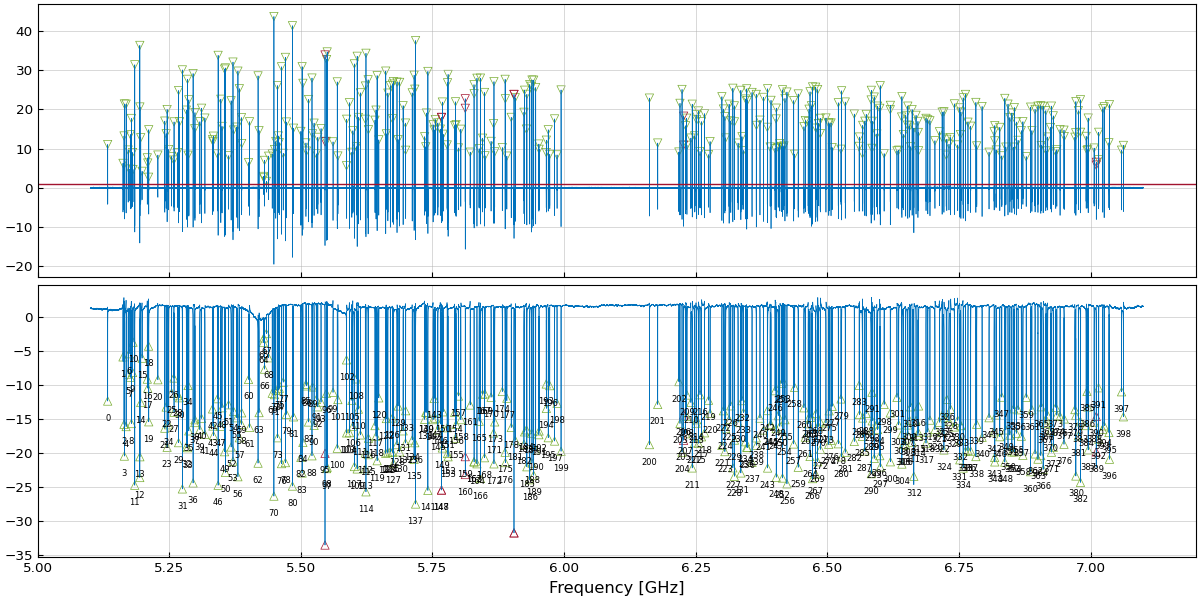

In [22]:
sw = 10 # even number
mph = .96
min_df = 0.0001
window = np.ones(sw)/sw
smooth_s21 = savgol_filter(dark_s21, 5, 4)
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = savgol_filter(ds21, 5, 4)
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
locs = np.insert(locs, 147, locs[147])
locs = np.insert(locs, 179, locs[179])
locs = np.delete(locs, 363)
heights = props['peak_heights']
heights = np.insert(heights, 147, heights[147])
heights = np.insert(heights, 179, heights[179])
heights = np.delete(heights, 363)
locs += 1
f0s = freqs[locs]

df0s = f0s[1:] - f0s[:-1]
df_mask = np.zeros(f0s.shape, dtype=bool)
too_close = df0s < min_df
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))


s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[2:], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='r')

ax['a'].scatter(freqs[locs[~too_close_mask]], heights[~too_close_mask], marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s[~too_close_mask], s21_mins[~too_close_mask], marker='^', c='None', edgecolor='g')
ax['a'].scatter(freqs[locs[too_close_mask]], heights[too_close_mask], marker='v', c='None', edgecolor='r')
ax['b'].scatter(f0s[too_close_mask], s21_mins[too_close_mask], marker='^', c='None', edgecolor='r')
for i, loc in enumerate(locs):
    ax['b'].annotate(f'{i}', (f0s[i], s21_mins[i]-5), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
ax['b'].set_xlabel('Frequency [GHz]')
print('Total: ', len(locs))
print('Sufficiently spaced with ', min_df*1e3 , 'MHz: ', len(locs[~too_close_mask]))

# f0s = f0s[~too_close_mask]
# locs = locs[~too_close_mask]

In [23]:
print(files)
nr_steps = len(files)
nr_kids = len(f0s)
sweeps = np.empty((nr_steps, len(freqs)))
smoothed_sweeps = np.empty((nr_steps, len(freqs)))
s21s = np.empty((nr_steps, nr_kids))
s21s[:] = np.nan
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
s0 = smooth_dark_s21[locs]
for i, file in enumerate(files):
    f, s21 = np.load(file)
    sweeps[i, :] = s21
    smooth_s21 = convolve(s21, window, mode='same')
    smoothed_sweeps[i, :] = smooth_s21
    s21s[i, :]  = smooth_s21[locs] - s0 

['.\\S21s_2025318_15h32\\S21_x2y0.npy', '.\\S21s_2025318_15h32\\S21_x3y0.npy', '.\\S21s_2025318_15h32\\S21_x4y0.npy', '.\\S21s_2025318_15h32\\S21_x5y0.npy', '.\\S21s_2025318_15h32\\S21_x6y0.npy', '.\\S21s_2025318_15h32\\S21_x7y0.npy', '.\\S21s_2025318_15h32\\S21_x8y0.npy', '.\\S21s_2025318_15h32\\S21_x9y0.npy', '.\\S21s_2025318_15h32\\S21_x10y0.npy', '.\\S21s_2025318_15h32\\S21_x11y0.npy', '.\\S21s_2025318_15h32\\S21_x12y0.npy', '.\\S21s_2025318_15h32\\S21_x13y0.npy', '.\\S21s_2025318_15h32\\S21_x14y0.npy', '.\\S21s_2025318_15h32\\S21_x15y0.npy', '.\\S21s_2025318_15h32\\S21_x16y0.npy', '.\\S21s_2025318_15h32\\S21_x17y0.npy', '.\\S21s_2025318_15h32\\S21_x18y0.npy', '.\\S21s_2025318_15h32\\S21_x19y0.npy', '.\\S21s_2025318_15h32\\S21_x20y0.npy', '.\\S21s_2025318_15h32\\S21_x21y0.npy', '.\\S21s_2025318_15h32\\S21_x22y0.npy', '.\\S21s_2025318_15h32\\S21_x23y0.npy']


Mean prominence:  4.361276816104059
total:  399
nr doubles:  23
ID: 94, secprom: 3.8, at: 19
ID: 95, secprom: 3.0, at: 19
ID: 112, secprom: 4.5, at: 13
ID: 113, secprom: 1.6, at: 13
ID: 125, secprom: 1.9, at: 2
ID: 147, secprom: 3.7, at: 9
ID: 148, secprom: 3.7, at: 9
ID: 159, secprom: 2.5, at: 19
ID: 160, secprom: 2.4, at: 19
ID: 162, secprom: 2.9, at: 1
ID: 163, secprom: 2.0, at: 3
ID: 179, secprom: 3.7, at: 16
ID: 180, secprom: 3.7, at: 16
ID: 193, secprom: 1.4, at: 14
ID: 205, secprom: 2.9, at: 4
ID: 206, secprom: 1.1, at: 2
ID: 271, secprom: 1.4, at: 9
ID: 312, secprom: 1.7, at: 10
ID: 343, secprom: 5.3, at: 1
ID: 344, secprom: 1.4, at: 3
ID: 379, secprom: 3.3, at: 19
ID: 382, secprom: 5.2, at: 5
ID: 389, secprom: 3.1, at: 11
low snr:  0
[]


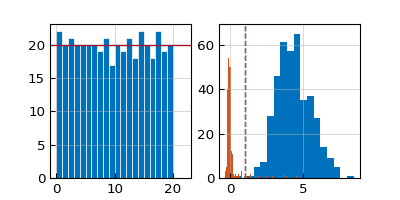

In [24]:
pos = np.empty((nr_kids)) # f0, 
pos[:] = np.nan
f0s_sel = np.empty((nr_kids)) # f0, 
f0s_sel[:] = np.nan
maxproms = []
secproms = []
mpp = 1
spp = 1
doubles = []
shifted = []
bads = []
df = 3e-4
for i in range(nr_kids):
    argsort = np.argsort(s21s[:, i])
    argmax = argsort[-1]
    sec_id = -2
    secargmax = argsort[sec_id]
    while np.abs(secargmax - argmax) == 1:
        sec_id -= 1
        secargmax = argsort[sec_id]
    argmin = argsort[0]
    max = s21s[:, i][argmax]
    secmax = s21s[:, i][secargmax]
    min = s21s[:, i][argmin]
    mean = np.mean(medfilt(s21s[:, i], 3))
    maxprom = max - mean
    secprom =  secmax - mean
    minprom = min - mean
    maxproms.append(maxprom)
    secproms.append(secprom)
    pos[i] = argmax
    f0s_sel[i] = f0s[i]
    if secprom > spp: 
        doubles.append([i, secprom, secargmax])
    # if maxprom > mpp and secprom < spp:
    #     pos[i] = argmax
    #     f0s_sel[i] = f0s[i]
    # elif maxprom > mpp and secprom > spp: 
    #     f0 = f0s[i]
    #     # if f0-f0s[i-1] < df or f0s[i+1]-f0 < df:
    #     #     print('yes')
    #     doubles.append([i, secprom, secargmax])
    # else:
    #     bads.append(i)
# for [idx,row,f0] in doubles[::-1]:
#     pos = np.insert(pos, idx,row)
#     f0s_sel = np.insert(f0s_sel, idx,f0)
print('Mean prominence: ', sum(maxproms)/nr_kids)
fig, ax = plt.subplot_mosaic('ab', figsize=(4,2))
hist = ax['a'].hist(pos, bins=np.arange(nr_steps+1), facecolor='b', edgecolor='w')
ax['b'].axvline(mpp, c='b', ls= '--')
ax['b'].axvline(spp, c='o', ls='--')
ax['a'].axhline(M_pxs, c='r')
ax['b'].hist(maxproms, bins='auto', color='b')
ax['b'].hist(secproms, bins='auto', color='o')
print('total: ', np.sum(~np.isnan(pos)))
print('nr doubles: ', len(doubles))
for double in doubles:
    print('ID: %d, secprom: %.1f, at: %d' % (double[0], double[1], double[2]))
print('low snr: ', len(bads))
print(bads)

KeyError: 'f0'

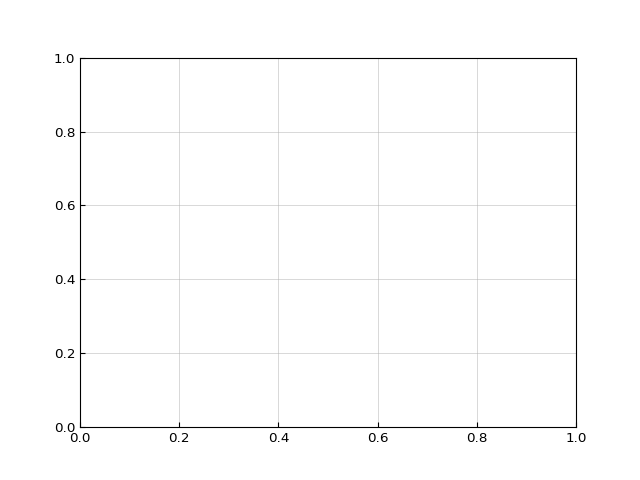

In [18]:
fig, ax = plt.subplots()
ids = np.arange(nr)
ids_m = np.arange(nr_kids)
ids_corr = np.rint(ids_m * nr/nr_kids)
ax.scatter(ids, main['f0'])
ax.scatter(ids_m, f0s_sel)
ax.scatter(ids_corr, f0s_sel)

4.162390734136364


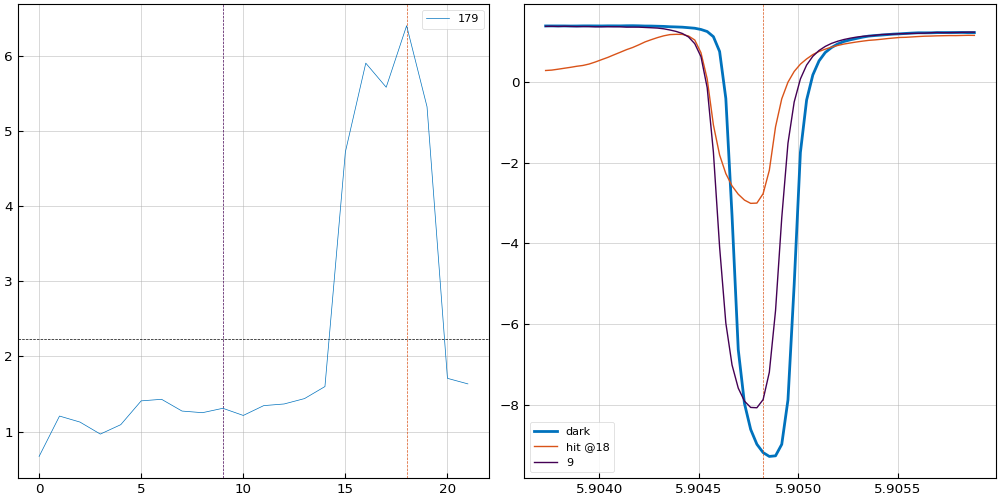

In [7]:
ids = [179]
fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
start = 0
stop = 20

steps = [9]
bw =  35
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)+1))

for id in ids:
    s21 = s21s[:, id]
    argsort = np.argsort(s21)
    argmax = argsort[-1]
    secargmax = argsort[-2]
    argmin = argsort[0]
    max = s21[argmax]
    secmax = s21[secargmax]
    min = s21[argmin]
    mean = np.mean(medfilt(s21, 3))
    maxprom = max - mean
    secprom =  secmax - mean
    minprom = min - mean
    print(maxprom)
    res = f0s[id]
    loc = locs[id]
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=2, label='dark', c='b')
    ax['a'].axvline(res, c='o', ls='--', lw=.5)
    ax['b'].axhline(mean, ls='--', lw=.5, c='k')
    if pos[id] != argmax:
        # argmax = int(pos[id])
        ax['b'].axvline(pos[id], ls='--', lw=.5, c='r')

    ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[argmax, loc-bw:loc+bw], lw=1, label='hit @' + str(argmax), c='o')
    ax['b'].axvline(argmax, ls='--', lw=.5, c='o')
    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21, lw=.5, label=str(id), c='b')
    # ax['b'].plot(medfilt(s21s[:, id], 3), lw=.5, label=str(id), c='r')

ax['b'].legend()
ax['a'].legend()

In [25]:
pos[95] = 19
pos[147] = 9
pos[113] = 13
pos[205] = 2
pos[206] = 4
pos[228] = 7
pos[271] = 10
pos[132] = 11
pos[18] = 15
pos[96] = 13
pos[160] = 18
pos[389] = 11
pos[379] = 18
pos[247] = 9
pos[299] = 16
pos[179] = 16

(16.0, 23.0)

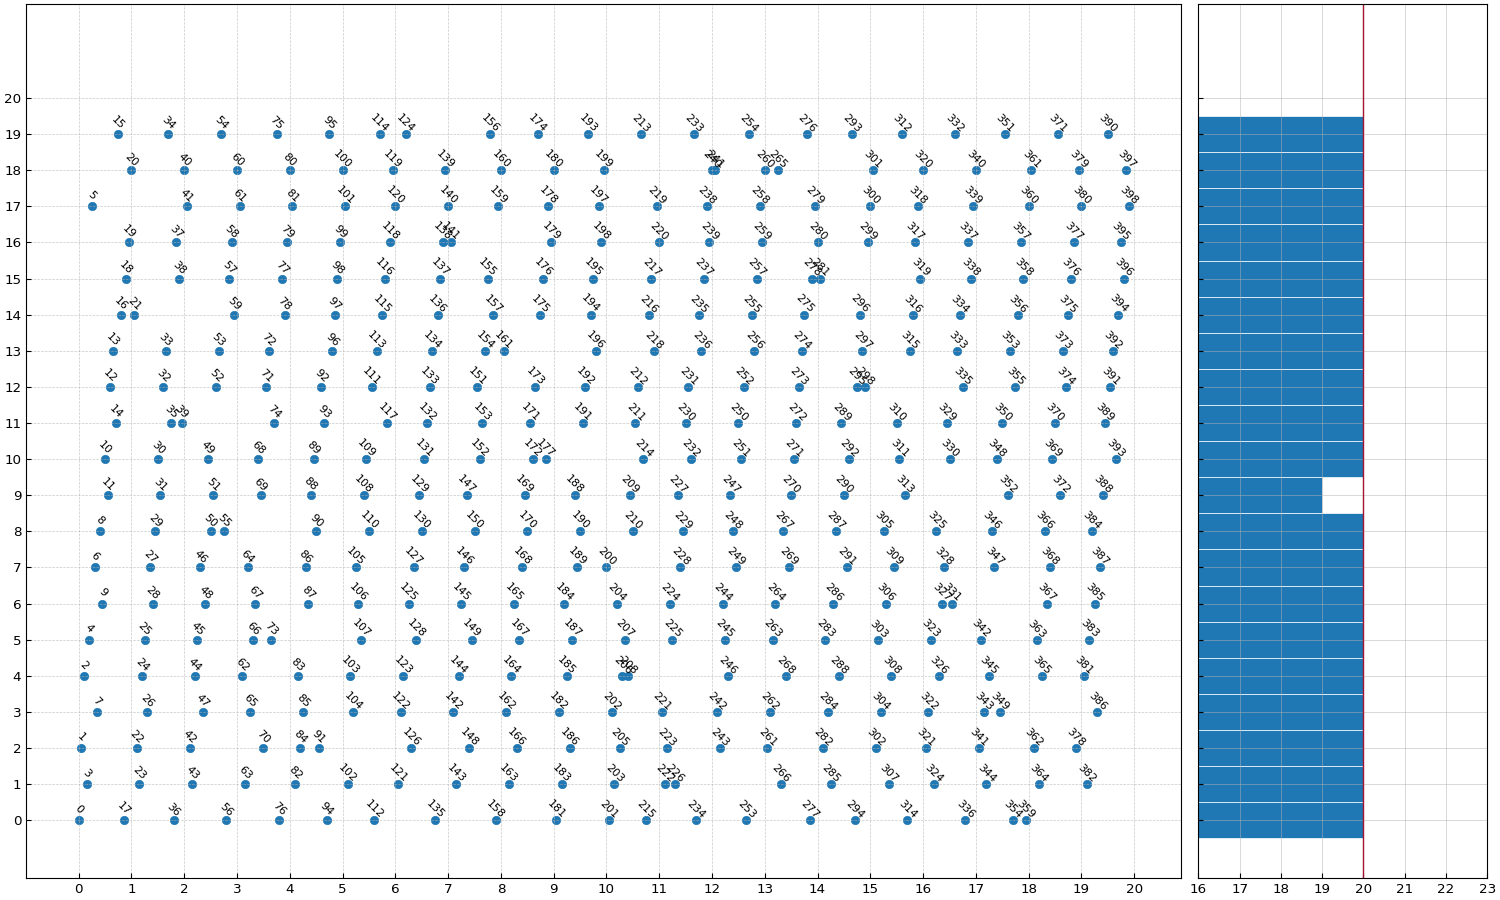

In [26]:
matrix = np.empty((M_pxs, N_pxs))
matrix[:] = np.nan
fig, ax = plt.subplot_mosaic('aaaab', figsize=(15,9), constrained_layout=True, sharey=True)   
x = np.arange(len(pos))/M_pxs
ax['a'].scatter(x, pos, c='tab:blue')
for id, row in enumerate(pos):
    ax['a'].annotate(id, (x[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
ax['a'].set_xticks(np.arange(0, M_pxs+1, 1))
ax['a'].set_yticks(np.arange(0, M_pxs+1, 1))
ax['a'].grid(True, which='both', linestyle='--', lw=.5)
ax['b'].hist(pos, bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(M_pxs, c='r')
ax['b'].set_xlim([M_pxs-4, M_pxs+3])
# ax['a'].set_xlim([30,33])


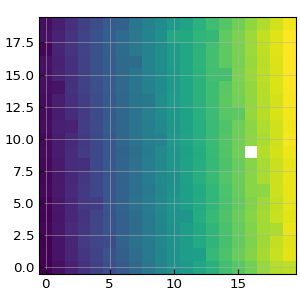

In [27]:
rows = [[] for _ in range(M_pxs)]
for id, row in enumerate(pos):
    if not np.isnan(row):
        rows[int(row)].append(int(id))
kids_derolled = np.empty((M_pxs, N_pxs))
kids_derolled[:] = np.nan   
for i, row in enumerate(rows):
    kids_derolled[i, :len(row)] = row
nans = [[9, 16]]
for i, j in nans:
    kids_derolled[i, j+1:] = kids_derolled[i, j:-1]
    kids_derolled[i, j] = np.nan
# kids_derolled = np.flip(kids_derolled, axis=0)
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids_derolled, cmap='viridis', origin='lower')

[266. 285. 307. 324. 344. 364. 382.   3.  23.  43.  63.  82. 102. 121.
 143. 163. 183. 203. 222. 226.]


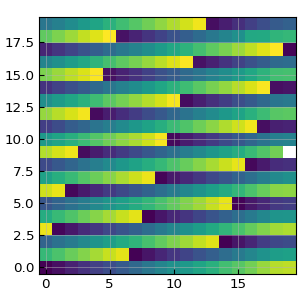

In [28]:
kids = copy(kids_derolled)
for i, row in enumerate(kids_derolled):
    kids[i] = np.roll(row, i*7)
# kids[0] = np.nan
# kids[-1] = np.nan
# kids[:, -1] = np.nan
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids, cmap='viridis', origin='lower')
print(kids[1])

In [29]:
main['row'] = np.empty(M_pxs*N_pxs)
main['row'][:] = np.nan
main['col'] = np.empty(M_pxs*N_pxs)
main['col'][:] = np.nan
main['f0_m'] = np.empty(M_pxs*N_pxs)
main['f0_m'][:] = np.nan
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        main['row'][idx] = i
        main['col'][idx] = j
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            main['f0_m'][idx] = meas_f
design = main['f0']
meas = main['f0_m']
nanmask = np.isnan(meas)
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)

KeyError: 'f0'

line
0.0029837604338331892


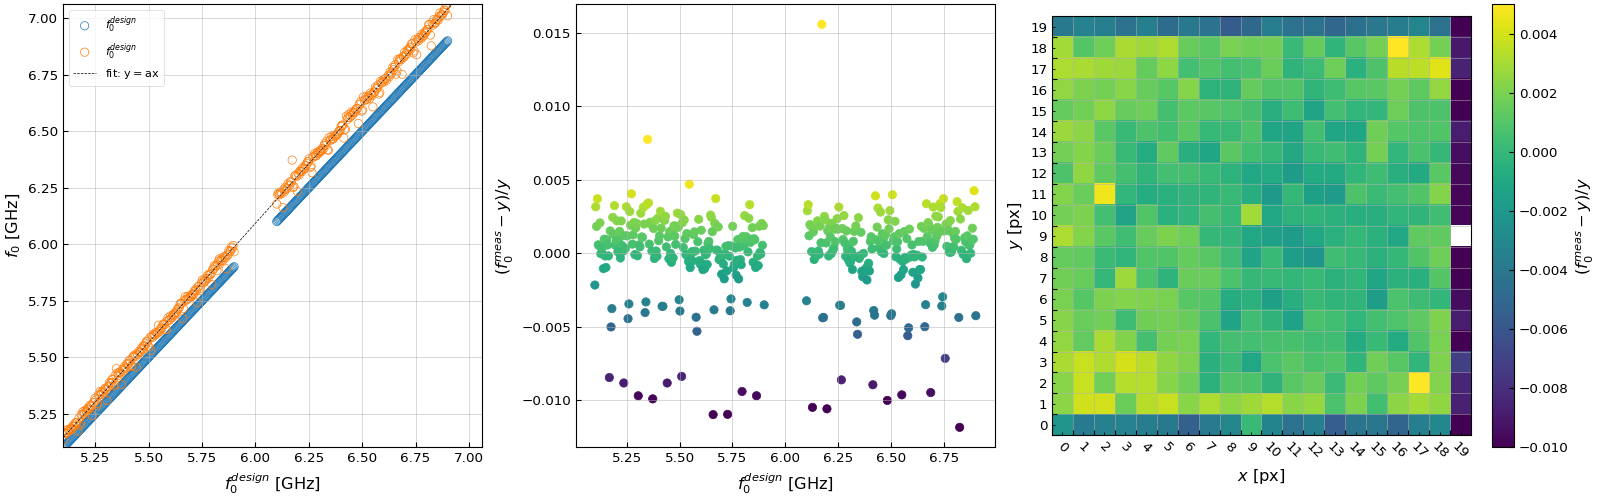

In [30]:
def linear(x, a, b):
    return a*x+b

def secorder(x, a, b, c):
    return a*x**2+b*x + c

line = linear
size=M_pxs
if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    print('line')
    popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
    design_fit = line(design, *popt)
    # fit = line(design, *popt)
    flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    design_fit = design
    label = 'f_0^{design}'
    save = 'nofit'
# popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
# design_fit = line(design, *popt)
df_f_fit = (meas - design_fit) / design_fit
df_f_map = df_f_fit[kid_id_board]


fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{design}$')
if line:
    ax['a'].plot(xfit, yfit, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend(loc='upper left')
clim = [-0.01, 0.005]
ax['b'].scatter(design, df_f_fit, c=df_f_fit, vmin=clim[0], vmax=clim[1], label='residual, $f_0-y_2$')
# for i, x in enumerate(design):
#     ax['b'].annotate(i, (x, df_f_corr[i]), fontsize=8, ha='center', va='center')
ax['b'].annotate
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
        if ~np.isnan(y):
            old_id = kid_id_board[i, j]
            new_id = kids[i, j]
            if old_id == new_id:
                c = 'w'
            else:
                c = 'r'
            # ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color=c)
# Major ticks
ax['c'].set_xticks(np.arange(0, size, 1)-0.5, minor=False)
ax['c'].set_yticks(np.arange(0, size, 1)-0.5, minor=False)
ax['c'].set_xticks(np.arange(0, size, 1), minor=True)
ax['c'].set_yticks(np.arange(0, size, 1), minor=True)
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(0, size, 1), minor=True, rotation=-45)
ax['c'].set_yticklabels(np.arange(0, size, 1), minor=True, rotation=0)
ax['c'].set_yticklabels([], minor=False)
ax['c'].set_xticklabels([], minor=False)
ax['c'].grid(which='major', linestyle='-', linewidth=0.5)
ax['c'].grid(which='minor', visible=False)

# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
print(np.std(df_f_fit[~nanmask]))
# fig, ax = plt.subplots()
# ax.scatter(pos[:, -1], df_f_corr[np.argsort(meas)])

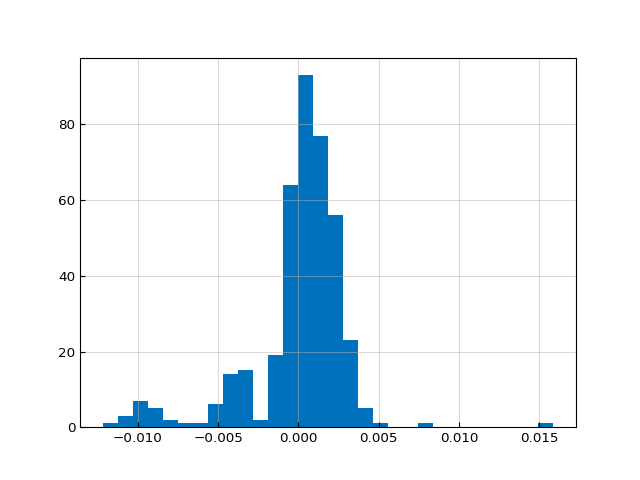

In [280]:
fig, ax = plt.subplots()
_ = ax.hist(df_f_fit, bins=30)

In [14]:
print(np.nanstd(df_f_fit[np.abs(df_f_fit)<0.02]))
print(np.nanstd(df_f_map[1:-1, :-1]))

0.0029837604338331892
0.0015699181734097174


In [308]:
nr_scans = s21s.shape[0]

def map():
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k] -= np.amin(s21s[:, k])
                    s21s[:, k] /= np.amax(s21s[:, k])
                    maps[i, j, nr] = s21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan

    return maps

maps = map()

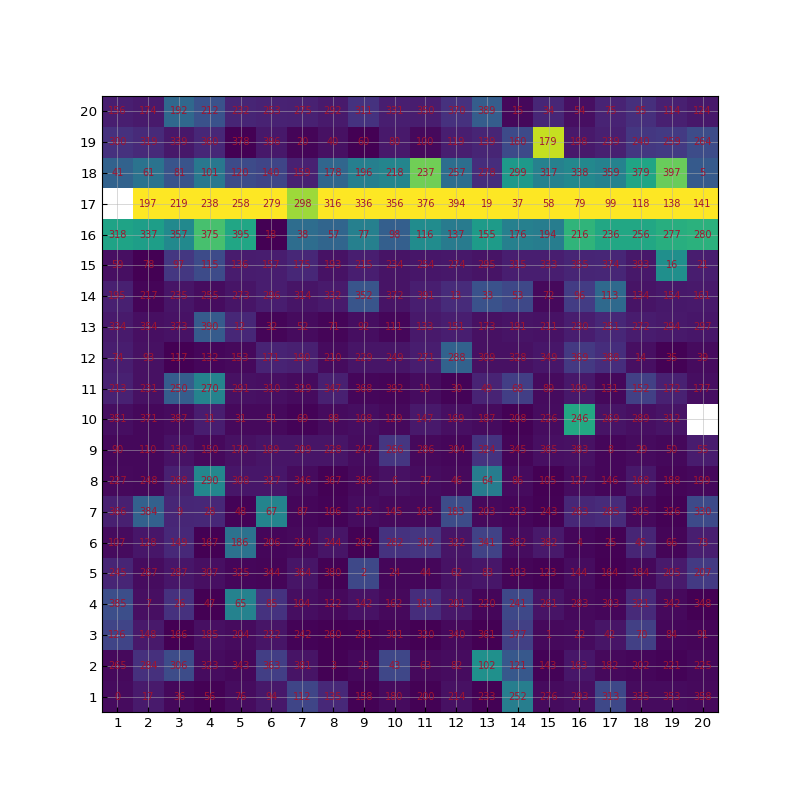

In [325]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(maps[:, :, 16], origin='lower', cmap='viridis')
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
            if ~np.isnan(y):
                new_id = kids[i, j]
                ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
_ =ax.set_xticks(np.arange(0, size, 1))
_ =ax.set_yticks(np.arange(0, size, 1))
# Labels for major ticks
_ =ax.set_xticklabels(np.arange(1, size+1, 1))
_ =ax.set_yticklabels(np.arange(1, size+1, 1))

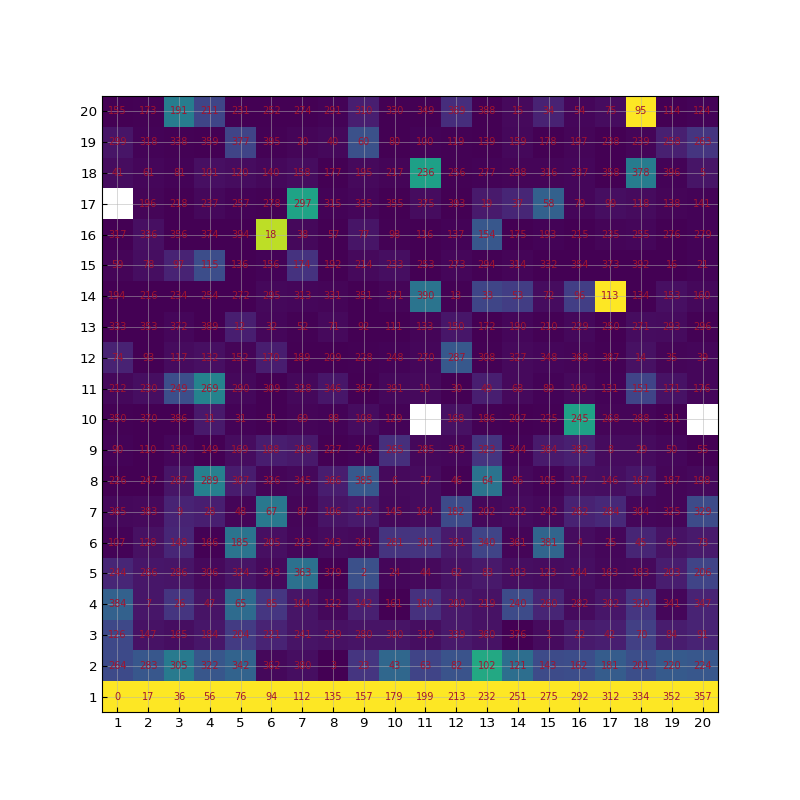

MovieWriter Pillow unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

In [231]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
            if ~np.isnan(y):
                new_id = kids[i, j]
                ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
ax.set_xticks(np.arange(0, size, 1))
ax.set_yticks(np.arange(0, size, 1))
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1))
ax.set_yticklabels(np.arange(1, size+1, 1))

def update(frame):
    cax.set_array(maps[:, :, frame])
    return cax,
ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
plt.show()
# ani.save('LT361_chip3_movie.gif', writer='Pillow')


In [19]:
def rel_freqs(f0, oct, Q, nr_kids):
    Q_spacing = Q*(2**(oct/nr_kids)-1)
    powers = np.arange(nr_kids)
    f0s = f0 * (1+Q_spacing/Q)**powers
    return f0s

def rel_freqs(f0, fN, nr_kids):
    oct = np.log2(fN/f0)
    gamma = 2**(oct/nr_kids)
    powers = np.arange(nr_kids)
    f0s = f0 * gamma**powers
    return f0s

def lin_freqs(f0, fN, nr_kids):
    return np.linspace(f0, fN, nr_kids, endpoint=True)

def line(x, a, b):
    return a*x+b


In [ ]:
fig, ax = plt.subplots()
sorted_fs = meas[~nanmask][sort_idx]
ids = np.arange(len(meas))[~nanmask]
df = 0.003
nr_kids = len(sorted_fs)
nr_lower = 504
nr_upper = nr_kids - nr_lower
ax.scatter(ids, sorted_fs, label='measured (sorted)')
popt, pcov = curve_fit(line, ids[:nr_lower], sorted_fs[:nr_lower])
plot_ids_lower = np.arange(np.amax(ids[:nr_lower])+1)
ax.plot(plot_ids_lower, line(plot_ids_lower, *popt), label='fit lower')  
a_l, b_l = popt[0], popt[1]
popt, pcov = curve_fit(line, ids[nr_lower:], sorted_fs[nr_lower:])
plot_ids_upper = np.arange(np.amax(plot_ids_lower)+1, np.amax(ids)+1)
ax.plot(plot_ids_upper, line(plot_ids_upper, *popt), label='fit upper')  
a_u, b_u = popt[0], popt[1]
a = (a_l+a_u)/2+0.000075
nibble_lower = line(ids[:nr_lower], a, b_l)
diff_lower = sorted_fs[:nr_lower] - nibble_lower
argmax_diff_lower = np.argmax(sorted_fs[:nr_lower] - nibble_lower)
max_diff_lower = diff_lower[argmax_diff_lower]
nibble_lower += max_diff_lower + df
ax.scatter(ids[:nr_lower], nibble_lower, label='nibble lower')
nibble_upper = line(ids[nr_lower:], a, b_l)
diff_upper = sorted_fs[nr_lower:] - nibble_upper
argmax_diff_upper = np.argmax(sorted_fs[nr_lower:] - nibble_upper)
max_diff_upper = diff_upper[argmax_diff_upper]
nibble_upper += max_diff_upper + df
ax.scatter(ids[nr_lower:], nibble_upper, label='nibble upper')
ax.legend()

nibble_freqs = np.hstack((nibble_lower, nibble_upper))[inverse_sort_idx]
master_array[:, 7][~nanmask] = nibble_freqs

In [ ]:
fingers = master_array[:, 3]
ids  = master_array[:, 0]
trim_design = master_array[:, 7]

fig, axes = plt.subplot_mosaic('abcde', figsize=(15,3), constrained_layout=True)
ax = axes['a']
ax.scatter(design, fingers, label='design f')
ax.scatter(meas, fingers, label='meas f')
ax.scatter(trim_design, fingers, label='nibble f')
ax.set_ylabel('finger length [um]')
ax.set_xlabel('frequency [GHz]')

def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

popt, pcov = curve_fit(poly, meas[~nanmask], fingers[~nanmask])
fit_fingers = poly(meas, *popt)   
ax.plot(meas, fit_fingers, c='k', lw=1)	
new_fingers = poly(trim_design, *popt)
nibble_fingers = new_fingers+(fingers-fit_fingers)
# trims = copy(meas)
trims = nibble_fingers - fingers
ax.scatter(trim_design, nibble_fingers, c='r', lw=1, label='nibble f+trim')
ax.legend()

ax = axes['b']
ax.scatter(ids, trims)
ax.set_ylabel('kids')
ax.set_xlabel('f0 [GHz]')
print('minimum trim = %.3f um' % np.nanmax(trims))
print('maximum trim = %.3f um' % np.nanmin(trims))

ax = axes['c']
ax.scatter(design, design, label='original design')
ax.scatter(design, meas, label='measured')
ax.scatter(design, trim_design, label='nibble design')
ax.set_ylabel('freqency [GHz]')
ax.set_xlabel('design frequency [GHz]')
ax.legend()
ax = axes['d']
df = (trim_design[~nanmask][sort_idx][1:]-trim_design[~nanmask][sort_idx][:-1])*1e3
ax.plot(df)
ax.set_ylabel('Spacing df [GHz]')
ax.set_xlabel('kids')
ax = axes['e']
ax.imshow(trims[kid_id_board], origin='lower')

master_array[:, 8] = nibble_fingers

In [ ]:
trims = (master_array[:, 3] - master_array[:, 8])[kid_id_board]
trims[-6,0]


In [34]:
trims = master_array[:, 3] - master_array[:, 8]
np.save('LT361_chip8_trims.npy', trims[kid_id_board])
np.save('LT361_chip8_new_fingers.npy', master_array[:, 8])
np.save('LT361_chip8_master.npy', master_array)

In [34]:
N_fingers = 13 # number of IDC fingers
nr_fingers_cut = 7
finger_length = 111.# full length of the fingers

In [ ]:
nr_fingers = 7
finger_length = 111
max_cut = 104
original_fingers= master_array[:, 3]
nibbled_fingers = master_array[:, 8]
original_cut = nr_fingers*finger_length - original_fingers
nibbled_cut = nr_fingers*finger_length - nibbled_fingers
nibble_two_fingers = ((original_cut // max_cut) != (nibbled_cut // max_cut)).astype(float)
nibble_two_fingers[nanmask] = np.nan
too_little_room_at_start_finger = (nibbled_cut % max_cut < np.nanmax(trims)).astype(float)
too_little_room_at_start_finger[nanmask] = np.nan
both = ((nibble_two_fingers==1)!=(too_little_room_at_start_finger==0))
fig, ax = plt.subplot_mosaic('ab', figsize=(8,4))
ax['a'].imshow((too_little_room_at_start_finger)[kid_id_board], origin='lower')
ax['b'].imshow((nibble_two_fingers)[kid_id_board], origin='lower')

In [ ]:
kid = kid_id_board[31,0]
print('old finger cut: ', 777-original_fingers[kid], (777-original_fingers[kid])//max_cut, ' fingers', (777-original_fingers[kid])%max_cut, ' rem')
print('new finger cut: ', 777-nibbled_fingers[kid],(777-nibbled_fingers[kid])//max_cut, ' fingers', (777-nibbled_fingers[kid])%max_cut, ' rem')
print('trimmed length: ', trims[kid])

In [ ]:
nibbled_fingers[too_little_room_at_start_finger.astype(bool)]

In [ ]:
old = master_array[:, 3]
new = master_array[:, 8]
nr_fingers = 7
finger_length = 111
max_cut = 104
trim_width = 4.5
min_trim = 13

for i, nl in enumerate(new):
    if np.isnan(nl):
        nl = nr_fingers*max_cut
    ol = old[i]
    of = ol // max_cut
    nf = nl // max_cut
    rem = nl - nf*max_cut
    if of != nf:
        print('two')
        # place symbol min_trim (x=of, y=max_cut-trim_min)
    if rem < min_trim:
        print(rem)
        # make symbol rem
        # place symbol rem+dy (x=nf, y=-dy)
    else:
        print(rem)
        # place symbol min_trim (x=nf, y=rem-min_trim)
        


    